# AI Competition for the Prediction of Water Level in Hangang River by the Flood Safety Management of Paldang Dam

# Meta data


## Water Data

- ymdhm : 년월일시분
- swl : 팔당댐 현재수위 (단위: El.m)
- inf : 팔당댐 유입량 (단위: m^3/s)
- sfw : 팔당댐 저수량 (단위: 만m^3)
- ecpc : 팔당댐 공용량 (단위: 백만m^3)
- tototf : 총 방류량 (단위: m^3/s)
- tide_level : 강화대교 조위 (단위: cm)
- wl_1018662 : 청담대교 수위 (단위: cm)
- fw_1018662 : 청담대교 유량 (단위: m^3/s)
- wl_1018680 : 잠수교 수위 (단위: cm)
- fw_1018680 : 잠수교 유량 (단위: m^3/s)
- wl_1018683 : 한강대교 수위 (단위: cm)
- fw_1018683 : 한강대교 유량 (단위: m^3/s)
- wl_1019630 : 행주대교 수위 (단위: cm)
- fw_1019630 : 행주대교 유량 (단위: m^3/s)

## RainFall Data

- YMDHM : 년월일시분
- rf_10184100 : 대곡교 강수량
- rf_10184110 : 진관교 강수량
- rf_10184140 : 송정동 강수량
---

## 기타 용어 정리

- 최고 수위 : 일정한 기간을 통하여 나타난 최고의 수위
- 최저 수위 : 일정한 기간을 통하여 나타난 최저의 수위
- 평수위 : 1년을 통하여 185일은 이보다 높은 수위
- 저수위 : 1년을 통하여 275일은 이보다 높은 수위
- 갈수위 : 1년을 통하여 355일은 이보다 높은 수위
- 일평균 수위 : 1일을 통하여 1시부터 24시까지 매시 수위의 합을 24로 나눈 수위
- 연평균 수위 : 1년을 통하여 일평균 수위의 합을 당해 연도의 일수로 나눈 수위
- 감조하천 : 조석의 영향으로 하천의 하류부에서 수위가 변하는 하천


## 주요 링크 모음

한강 홍수 통제소
- http://www.hrfco.go.kr/sumun/rainfallList.do#

한국 수자원 공사
- https://www.kwater.or.kr/main.do?s_mid=1

정보공개
- https://www.open.go.kr/com/main/mainView.do?mainBgGubun=search

In [4]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # 시각화
import seaborn as sns

# 추가 시각화
from colorama import Fore

# MAE MSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Supress warnings 
import warnings 
warnings.filterwarnings('ignore')

# 재현성
np.random.seed(7)

# 모델들, 성능 평가
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from functools import partial

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna
import os

# MICE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# import openpyxl

# flag setting
data_reducing = False ## memory reducing technique
feature_reducing = False ## feature extraction (curse of dimensionality)


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 대회 metric
def dacon_metric(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    if r2 < 0:
      r2 = 999
    return rmse / r2

evaluation_metric = dacon_metric

## data load

In [11]:
base_path = './competition_data/'

df_water = pd.DataFrame()
df_rf = pd.DataFrame()

# ymdhm을 불러올때부터 Datetime dtype으로 불러오기
for filename in os.listdir(base_path + 'water_data'):
    df_water = pd.concat([df_water,pd.read_csv(base_path + f'water_data/{filename}', parse_dates=['ymdhm'])])
for filename in os.listdir(base_path + 'rf_data'):
    df_rf = pd.concat([df_rf,pd.read_csv(base_path + f'rf_data/{filename}', parse_dates=['ymdhm'])])

df_water = df_water.sort_values(by = ['ymdhm'])
df_rf = df_rf.sort_values(by = ['ymdhm'])
df = pd.concat([df_water,df_rf.drop(columns='ymdhm')], axis = 1,)
df.reset_index(inplace=True, drop =True)

## Missing Values | 결측치 확인

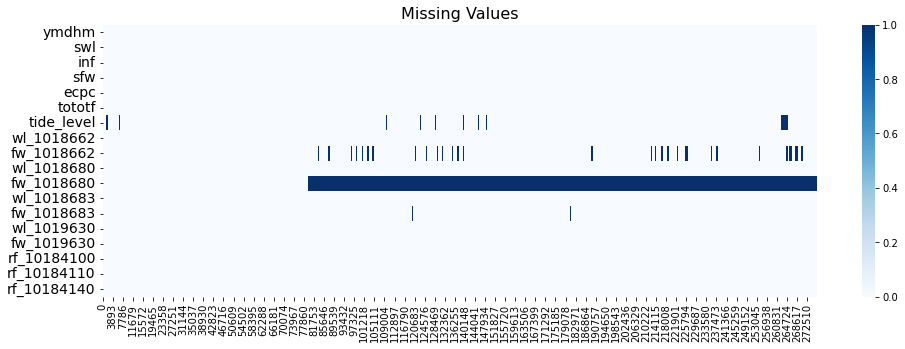

In [12]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

In [13]:
# 결측치가 많고 그나마 있는 데이터도 0인 feature Drop
df.drop(columns=['fw_1018680'], inplace = True)

In [14]:
df.rename(columns={'ymdhm':'date'}, inplace = True)

In [15]:
# test구간인 6월 1일 부터 wl(water level | 수위) feature 값이 모두 0
df.tail(6913)

,date,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
269423,2022-05-31 23:50:00,25.19,140.56,218.36,25.64,140.56,173.0,278.7,269.40,276.2,275.0,70.09,270.3,482.26,0.0,0.0,0.0
269424,2022-06-01 00:00:00,25.19,140.60,218.36,25.64,140.60,162.0,0.0,269.40,0.0,0.0,8.23,0.0,471.08,0.0,0.0,0.0
269425,2022-06-01 00:10:00,25.19,140.78,218.36,25.64,140.78,151.0,0.0,280.22,0.0,0.0,28.82,0.0,449.12,0.0,0.0,0.0
269426,2022-06-01 00:20:00,25.20,755.90,218.73,25.27,140.90,141.0,0.0,296.87,0.0,0.0,12.35,0.0,417.17,0.0,0.0,0.0
269427,2022-06-01 00:30:00,25.19,0.00,218.36,25.64,140.94,130.0,0.0,302.53,0.0,0.0,53.52,0.0,386.43,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,2022-07-18 23:10:00,25.04,259.23,212.86,31.14,259.23,510.0,0.0,319.84,0.0,0.0,-456.41,0.0,974.40,0.0,0.0,0.0
276332,2022-07-18 23:20:00,25.04,260.46,212.86,31.14,260.46,492.0,0.0,314.01,0.0,0.0,-717.30,0.0,1006.88,0.0,0.0,0.0
276333,2022-07-18 23:30:00,25.04,259.37,212.86,31.14,259.37,475.0,0.0,387.55,0.0,0.0,-843.37,0.0,1039.90,0.0,0.0,0.0
276334,2022-07-18 23:40:00,25.04,259.13,212.86,31.14,259.13,458.0,0.0,454.91,0.0,0.0,-1023.37,0.0,1073.46,0.0,0.0,0.0


In [16]:
# MICE sklean 구현
imputed_df = df.copy()
imputed_df = imputed_df.drop(columns='date')

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,
                      verbose = 2, 
                      max_iter = 30,
                      tol = 1e-10,
                      imputation_order='roman')
# fit on the copied dataset
imp.fit(imputed_df)
print('-------- complete fitting -------')
# transform the copied dataset
imputed_df = pd.DataFrame(imp.transform(imputed_df), columns=imputed_df.columns)
imputed_df = pd.concat([df.date, imputed_df], axis=1)

[IterativeImputer] Completing matrix with shape (276336, 16)
[IterativeImputer] Ending imputation round 1/30, elapsed time 1.19
[IterativeImputer] Change: 23665.74542417353, scaled tolerance: 2.985412e-06 
[IterativeImputer] Ending imputation round 2/30, elapsed time 2.34
[IterativeImputer] Change: 1110.5764464879387, scaled tolerance: 2.985412e-06 
[IterativeImputer] Ending imputation round 3/30, elapsed time 3.47
[IterativeImputer] Change: 746.9797268907801, scaled tolerance: 2.985412e-06 
[IterativeImputer] Ending imputation round 4/30, elapsed time 4.61
[IterativeImputer] Change: 554.461123578112, scaled tolerance: 2.985412e-06 
[IterativeImputer] Ending imputation round 5/30, elapsed time 5.74
[IterativeImputer] Change: 411.5200024996631, scaled tolerance: 2.985412e-06 
[IterativeImputer] Ending imputation round 6/30, elapsed time 6.88
[IterativeImputer] Change: 305.4277528837769, scaled tolerance: 2.985412e-06 
[IterativeImputer] Ending imputation round 7/30, elapsed time 8.02
[I

In [17]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         276336 non-null  datetime64[ns]
 1   swl          276336 non-null  float64       
 2   inf          276336 non-null  float64       
 3   sfw          276336 non-null  float64       
 4   ecpc         276336 non-null  float64       
 5   tototf       276336 non-null  float64       
 6   tide_level   276336 non-null  float64       
 7   wl_1018662   276336 non-null  float64       
 8   fw_1018662   276336 non-null  float64       
 9   wl_1018680   276336 non-null  float64       
 10  wl_1018683   276336 non-null  float64       
 11  fw_1018683   276336 non-null  float64       
 12  wl_1019630   276336 non-null  float64       
 13  fw_1019630   276336 non-null  float64       
 14  rf_10184100  276336 non-null  float64       
 15  rf_10184110  276336 non-null  floa

## feature engineering

stationary 분석을 위한 rolling mean, rolling std

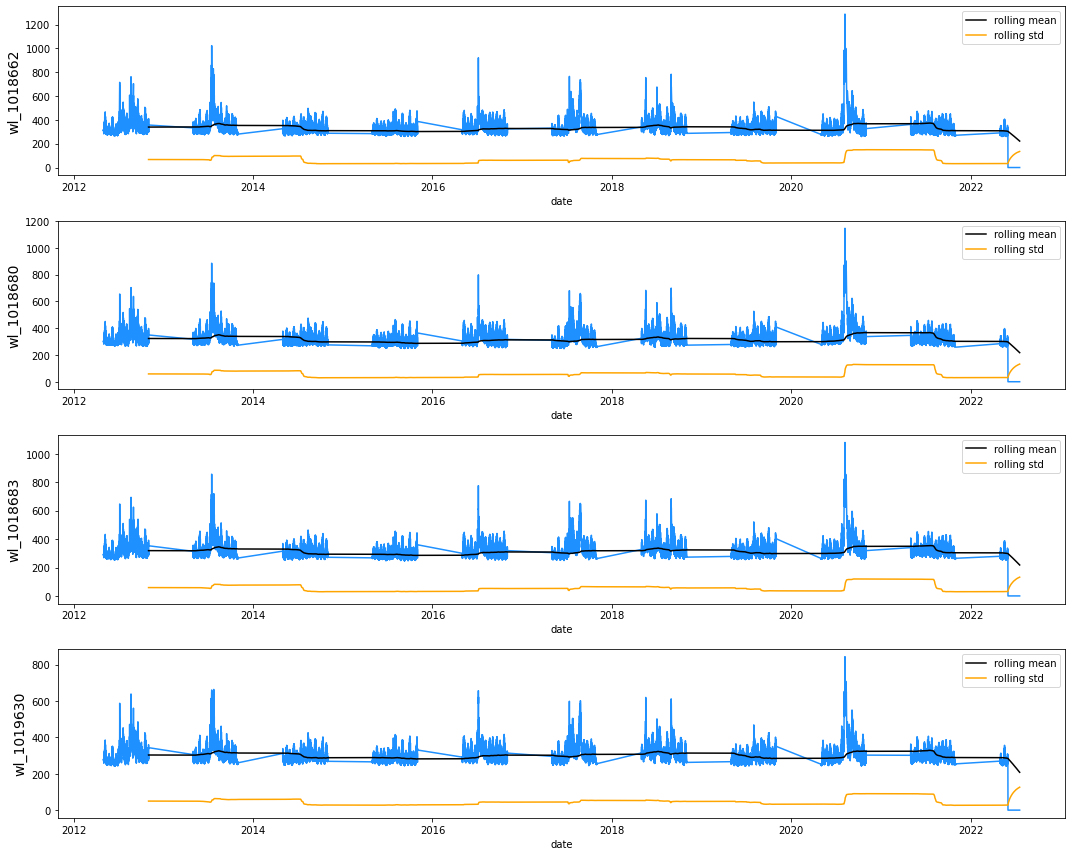

In [18]:
# A year has 26469 rows except 2022 year
rolling_window = 26469
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=imputed_df['date'], y=imputed_df['wl_1018662'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=imputed_df['date'], y=imputed_df['wl_1018662'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=imputed_df['date'], y=imputed_df['wl_1018662'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_ylabel(ylabel='wl_1018662', fontsize=14)

sns.lineplot(x=imputed_df['date'], y=imputed_df['wl_1018680'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=imputed_df['date'], y=imputed_df['wl_1018680'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=imputed_df['date'], y=imputed_df['wl_1018680'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_ylabel(ylabel='wl_1018680', fontsize=14)

sns.lineplot(x=imputed_df['date'], y=imputed_df['wl_1018683'], ax=ax[2], color='dodgerblue')
sns.lineplot(x=imputed_df['date'], y=imputed_df['wl_1018683'].rolling(rolling_window).mean(), ax=ax[2], color='black', label='rolling mean')
sns.lineplot(x=imputed_df['date'], y=imputed_df['wl_1018683'].rolling(rolling_window).std(), ax=ax[2], color='orange', label='rolling std')
ax[2].set_ylabel(ylabel='wl_1018683', fontsize=14)

sns.lineplot(x=imputed_df['date'], y=imputed_df['wl_1019630'], ax=ax[3], color='dodgerblue')
sns.lineplot(x=imputed_df['date'], y=imputed_df['wl_1019630'].rolling(rolling_window).mean(), ax=ax[3], color='black', label='rolling mean')
sns.lineplot(x=imputed_df['date'], y=imputed_df['wl_1019630'].rolling(rolling_window).std(), ax=ax[3], color='orange', label='rolling std')
ax[3].set_ylabel(ylabel='wl_1019630', fontsize=14)

plt.tight_layout()
plt.show()

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'inf','tototf','wl_1018662', 'wl_1018680', 'wl_1018683','wl_1019630'
]
# core_columns = imputed_df.columns.tolist()[1:]
for column in core_columns:
    decomp = seasonal_decompose(imputed_df[column], period=rolling_window, model='additive', extrapolate_trend='freq')
    imputed_df[f"{column}_trend"] = decomp.trend
    imputed_df[f"{column}_seasonal"] = decomp.seasonal

In [20]:
imputed_df.head()

,date,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,...,tototf_trend,tototf_seasonal,wl_1018662_trend,wl_1018662_seasonal,wl_1018680_trend,wl_1018680_seasonal,wl_1018683_trend,wl_1018683_seasonal,wl_1019630_trend,wl_1019630_seasonal
0,2012-05-01 00:00:00,24.800,555.0,219.07,24.93,555.0,445.0,310.7,469.05,300.2,...,507.039990,-319.339047,329.762478,-22.658283,311.483148,-17.899862,311.435652,-17.464740,297.204573,-12.353813
1,2012-05-01 00:10:00,24.794,464.6,218.86,25.15,562.9,449.0,314.7,498.00,300.2,...,507.053468,-318.225665,329.763324,-22.294276,311.484040,-18.263177,311.436360,-17.737174,297.205192,-12.444463
2,2012-05-01 00:20:00,24.789,478.1,218.69,25.31,576.4,451.0,313.7,490.68,301.2,...,507.066947,-316.935007,329.764171,-22.293906,311.484932,-18.444670,311.437068,-18.100514,297.205811,-12.444210
3,2012-05-01 00:30:00,24.789,464.8,218.69,25.31,563.1,452.0,311.7,476.21,301.2,...,507.080425,-311.191602,329.765018,-21.475344,311.485824,-18.717073,311.437776,-17.372949,297.206430,-12.443965
4,2012-05-01 00:40:00,24.789,478.1,218.69,25.31,576.4,450.0,311.7,476.21,301.2,...,507.093904,-315.389128,329.765865,-21.293156,311.486716,-16.807653,311.438484,-16.645380,297.207050,-12.534628


<AxesSubplot:>

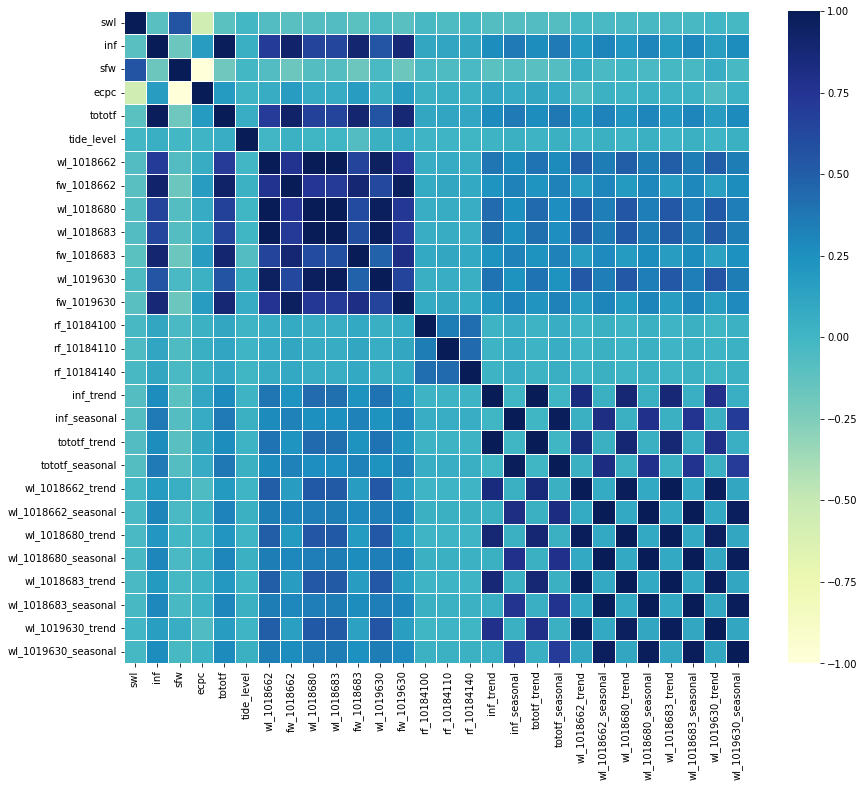

In [21]:
plt.figure(figsize = (14,12))
sns.heatmap(imputed_df.corr(),
            annot = False,
           cmap = "YlGnBu",
           linewidths = "0.5",
           vmin = -1)

In [22]:
# target features
target_col = ['wl_1018662','wl_1018680','wl_1018683','wl_1019630']

In [23]:
X = imputed_df.drop(columns = target_col)
y = pd.concat([imputed_df['date'],imputed_df[target_col]],axis = 1)

In [24]:
# train, test split point
test_split_point = '2022-06-01 00:00:00'

In [25]:
X_train = X[X.date < test_split_point]
y_train = y[y.date < test_split_point]
X_test = X[X.date >= test_split_point]
y_test = y[y.date >= test_split_point]

In [26]:
# 날짜 데이터 ordinal encoding
def create_date_features(df):
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofmonth'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute
    df['dayofyear'] = df['date'].dt.dayofyear    
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date'] = df.index

In [27]:
create_date_features(X_train)
create_date_features(X_test)
y_train = y_train.drop(columns = ['date'])
y_test = y_test.drop(columns = ['date'])

In [28]:
X_train.head()

,date,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018683,fw_1019630,...,wl_1019630_seasonal,year,quarter,month,dayofmonth,dayofweek,hour,minute,dayofyear,weekofyear
0,0,24.800,555.0,219.07,24.93,555.0,445.0,469.05,729.80,540.18,...,-12.353813,2012,2,5,1,1,0,0,122,18
1,1,24.794,464.6,218.86,25.15,562.9,449.0,498.00,731.48,540.18,...,-12.444463,2012,2,5,1,1,0,10,122,18
2,2,24.789,478.1,218.69,25.31,576.4,451.0,490.68,726.42,540.18,...,-12.444210,2012,2,5,1,1,0,20,122,18
3,3,24.789,464.8,218.69,25.31,563.1,452.0,476.21,726.42,552.17,...,-12.443965,2012,2,5,1,1,0,30,122,18
4,4,24.789,478.1,218.69,25.31,576.4,450.0,476.21,707.17,564.29,...,-12.534628,2012,2,5,1,1,0,40,122,18


## Modeling | 모델링

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit


def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    max_depth = trial.suggest_int('max_depth', 0, 16)
    max_leaves = trial.suggest_int('max_leaves', 128, 1023) # 2**max_depth - 1
    n_estimators = trial.suggest_int('n_estimators', 200, 600)
    eta = trial.suggest_uniform('eta', 0.001, 0.3)

    # multi Output regressor
    if y.shape[1] > 1:
        model = RegressorChain(
                    XGBRegressor(n_estimators=n_estimators,
                    max_depth=max_depth,
                    max_leaves=max_leaves,
                    eta=eta,
                    tree_method='gpu_hist' # gpu 사용시
                    # tree_method='hist'
                    ),
                    order=[0, 1, 2, 3])
        model = Pipeline([('reg', model)])
    else:
    # single output regressor
        model = XGBRegressor(n_estimators=n_estimators,
                          max_depth=max_depth,
                          max_leaves=max_leaves,
                          eta=eta,
                          tree_method='gpu_hist', # gpu 사용시
                          # tree_method='hist'
                          n_jobs=-1)
    
    # K-Fold Cross validation
    folds = KFold(n_splits=K)
    losses = []
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        # loss = mean_absolute_error(y_val, preds)
        loss = dacon_metric(y_val, preds)
        losses.append(loss)
#     #Time Series Split (Expanded)
#     folds = TimeSeriesSplit(n_splits=K)
#     losses = []
#     for (train_index, valid_index) in folds.split(X,y):
#         X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
#         y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
#         model.fit(X_train, y_train)
#         preds = model.predict(X_valid)
#         # loss = mean_absolute_error(y_val, preds)
#         loss = dacon_metric(y_valid, preds)
#         losses.append(loss)

    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [30]:
from functools import partial
# Optuna Run!

K = 25 # Kfold 수
study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 Loss 최적값을 구할 건지.
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)
study.optimize(opt_func, n_trials=5)

[I 2022-08-30 13:08:21,855] A new study created in memory with name: no-name-0a23907c-69c7-4de0-9404-cd611ca37afd
[W 2022-08-30 13:08:21,956] Trial 0 failed because of the following error: XGBoostError('[13:08:21] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.\nStack trace:\n  [bt] (0) 1   libxgboost.dylib                    0x000000017a0747a8 dmlc::LogMessageFatal::~LogMessageFatal() + 124\n  [bt] (1) 2   libxgboost.dylib                    0x000000017a114da0 xgboost::gbm::GBTree::ConfigureUpdaters() + 436\n  [bt] (2) 3   libxgboost.dylib                    0x000000017a11498c xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::b

XGBoostError: [13:08:21] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000017a0747a8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000017a114da0 xgboost::gbm::GBTree::ConfigureUpdaters() + 436
  [bt] (2) 3   libxgboost.dylib                    0x000000017a11498c xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > > const&) + 964
  [bt] (3) 4   libxgboost.dylib                    0x000000017a13087c xgboost::LearnerConfiguration::Configure() + 1016
  [bt] (4) 5   libxgboost.dylib                    0x000000017a130b9c xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000017a078524 XGBoosterUpdateOneIter + 140
  [bt] (6) 7   libffi.8.dylib                      0x0000000101c0804c ffi_call_SYSV + 76
  [bt] (7) 8   libffi.8.dylib                      0x0000000101c0574c ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-38-darwin.so        0x0000000101ad451c _ctypes_callproc + 1196



In [22]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [23]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [24]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [25]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

In [26]:
model = RegressorChain(XGBRegressor(**study.best_trial.params, 
                                    tree_method='gpu_hist'
                                    # tree_method='hist'
                                    ), 
                       order=[0, 1, 2, 3]
                       )

In [27]:
model.fit(X_train, y_train)

print("Prediction with Best Estimator")
pred_test = model.predict(X_test)
# np.sqrt(mean_squared_error(y_test, pred_test))
# optuna_test_score = evaluation_metric(y_test, pred_test)
# print("Optuna Test RMSE/R2 Score : %.4f" % optuna_test_score)

# r2_score(y_test, pred_test)

# # save_model(model, 'fitted_model')

In [28]:
submission = pd.read_csv('../input/dacon-competition-data/sample_submission.csv')

for idx, sub_col in enumerate(submission.columns[1:]):
    submission[sub_col] = pred_test[idx]
submission.to_csv('./submission',index=False)

# Thank you